## Usando uma base de seguros, precisamos prever o preço do seguro

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Series Temporais/Case/insurance.xlsx')

In [3]:
df.head()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              1341 non-null   int64  
 1   sexo               1338 non-null   object 
 2   imc                1341 non-null   float64
 3   quantidade_filhos  1341 non-null   int64  
 4   fumante            1341 non-null   object 
 5   regiao             1341 non-null   object 
 6   custos_seguro      1341 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.5+ KB


In [5]:
# Cuidando dos nulos
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              1338 non-null   int64  
 1   sexo               1338 non-null   object 
 2   imc                1338 non-null   float64
 3   quantidade_filhos  1338 non-null   int64  
 4   fumante            1338 non-null   object 
 5   regiao             1338 non-null   object 
 6   custos_seguro      1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [7]:
# Cuidando das variéveis Dummies
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [8]:
le.fit(df.sexo)
df.sexo = le.transform(df.sexo)

le.fit(df.fumante)
df.fumante =  le.transform(df.fumante)

le.fit(df.regiao)
df.regiao = le.transform(df.regiao)

In [9]:
df.head()
# Female - 0 / Male - 1

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.560,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Usando o MinMaxScaler para deixar todas em escalas parecidas

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df), index= df.index, columns= df.columns)


In [11]:
df_norm.describe()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.505232,0.395583,0.218984,0.204783,0.505232,0.193916
std,0.305434,0.500160,0.164067,0.241099,0.403694,0.368295,0.193301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195652,0.000000,0.278080,0.000000,0.000000,0.333333,0.057757
50%,0.456522,1.000000,0.388485,0.200000,0.000000,0.666667,0.131849
75%,0.717391,1.000000,0.504002,0.400000,0.000000,0.666667,0.247700
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='custos_seguro', ylabel='Count'>

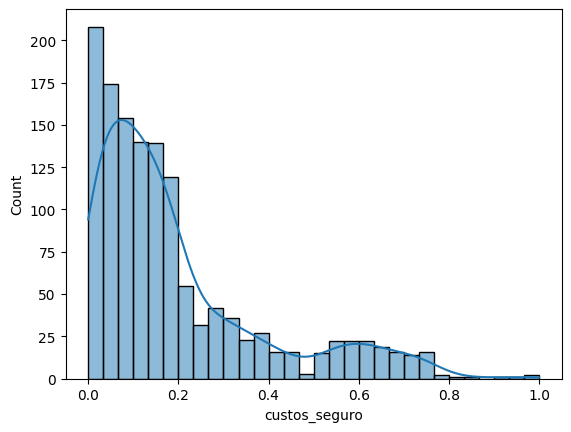

In [12]:
sns.histplot(data=df_norm, x='custos_seguro', kde=True)
# Podemos observar que temos uma quantidade grande dos seguros em valores mais baixos

Entendendo melhor a correlação entre as variáveis

In [13]:
df_norm.corr()
# Aparentemente ser fumante está bem relacionado com preços mais altos de seguro, bem como a Idade

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
idade,1.000000,-0.020856,0.109214,0.042469,-0.025019,0.002127,0.299008
sexo,-0.020856,1.000000,0.046438,0.017163,0.076185,0.004588,0.057292
imc,0.109214,0.046438,1.000000,0.012867,0.003715,0.157591,0.198285
quantidade_filhos,0.042469,0.017163,0.012867,1.000000,0.007673,0.016569,0.067998
fumante,-0.025019,0.076185,0.003715,0.007673,1.000000,-0.002181,0.787251
regiao,0.002127,0.004588,0.157591,0.016569,-0.002181,1.000000,-0.006208
custos_seguro,0.299008,0.057292,0.198285,0.067998,0.787251,-0.006208,1.000000


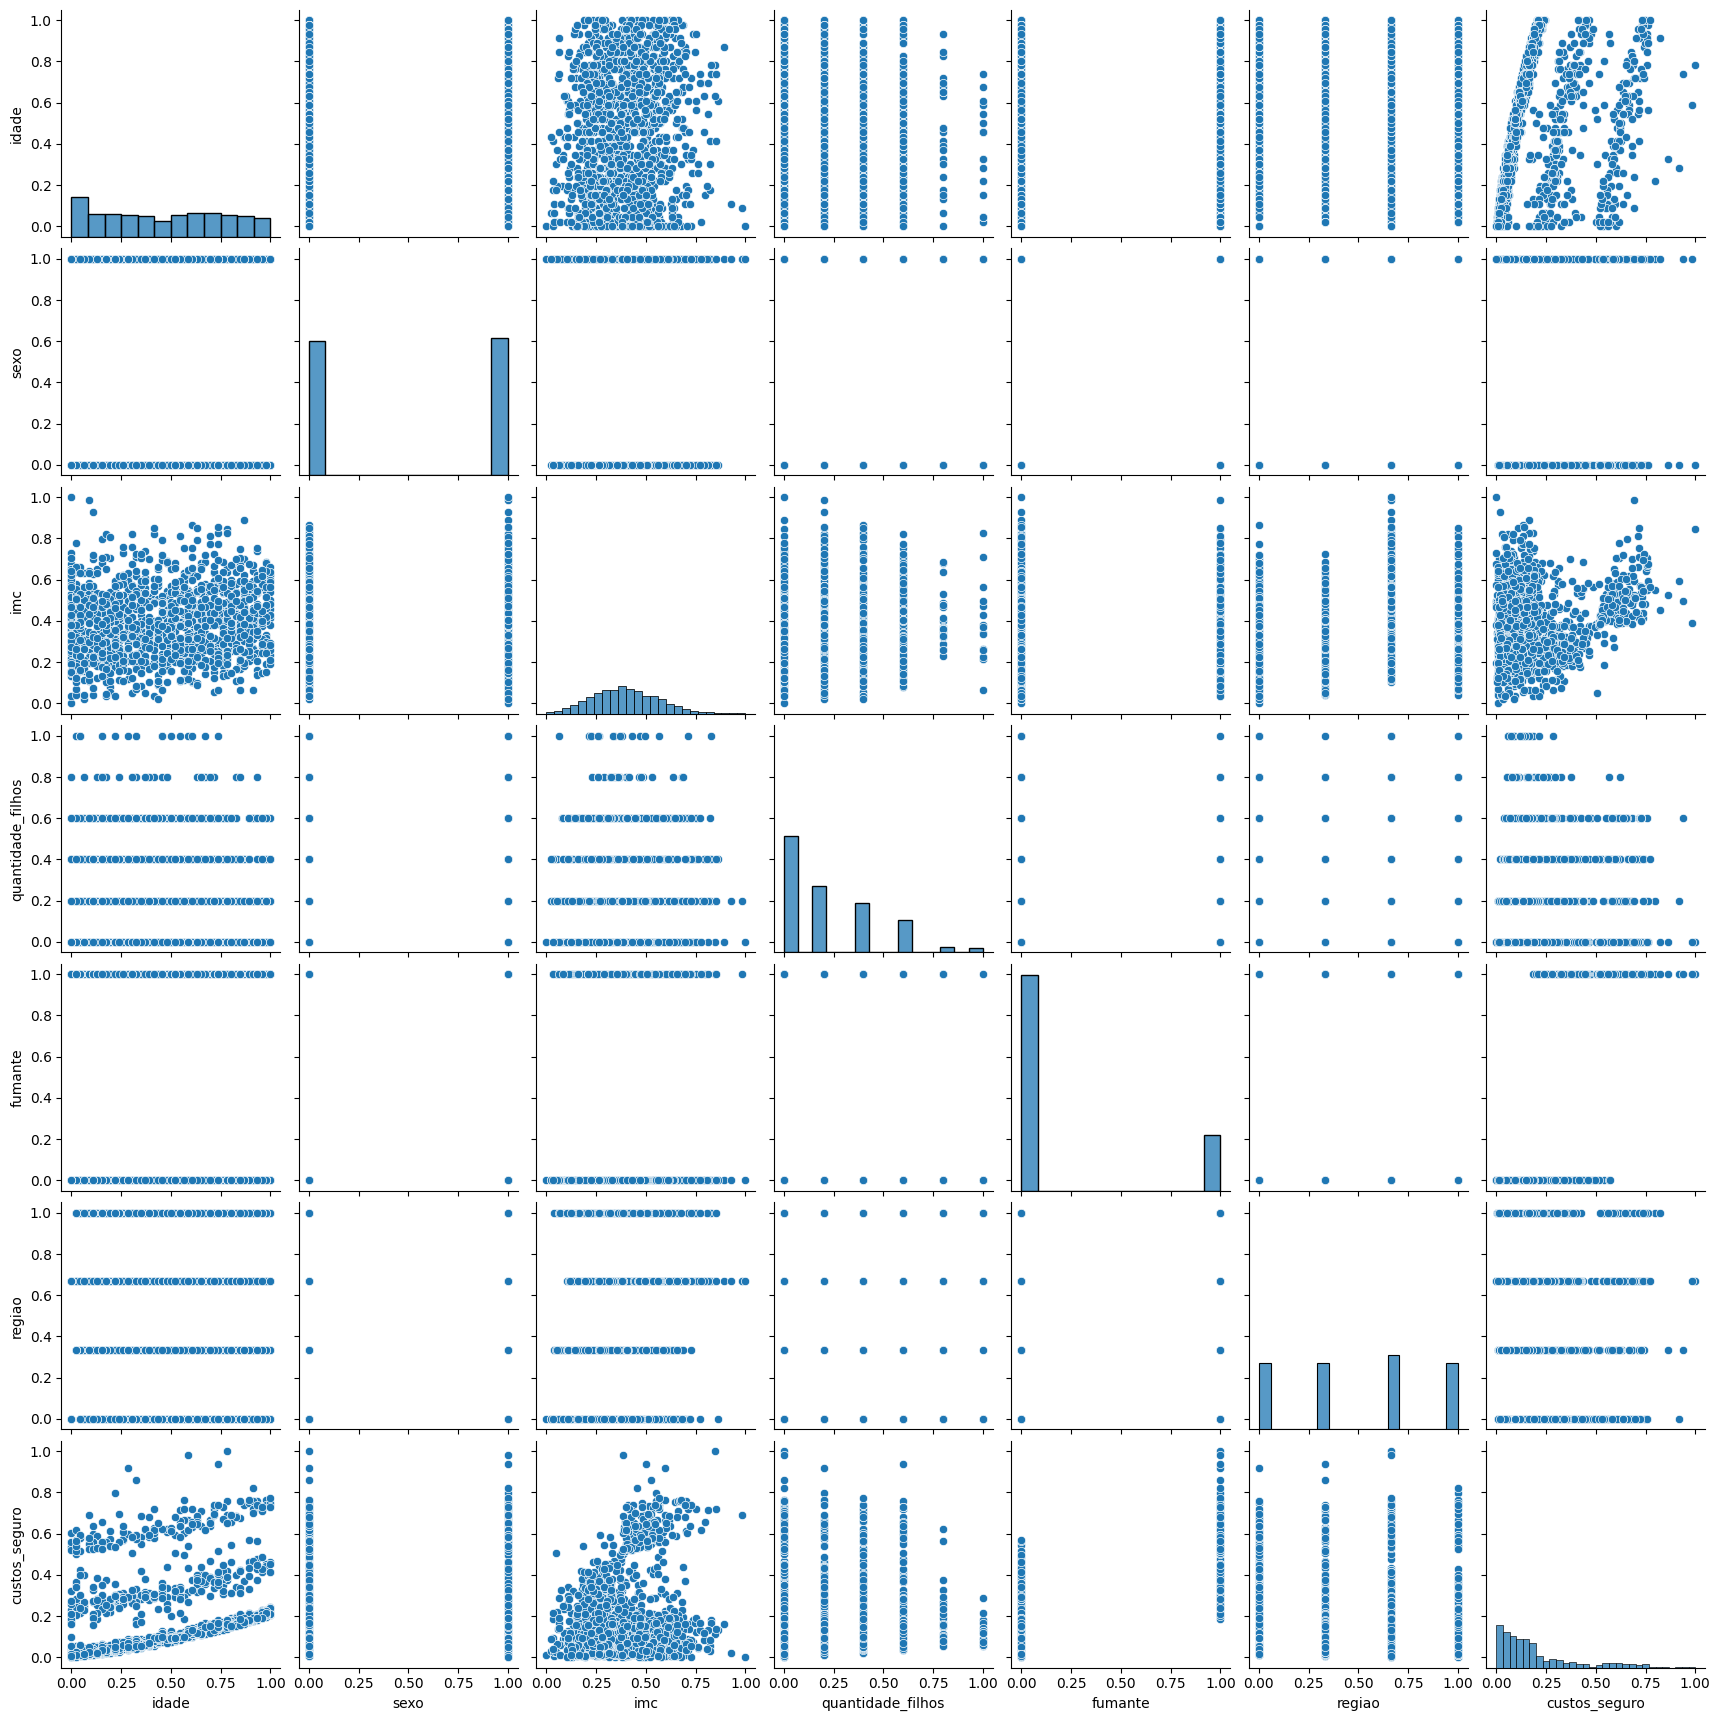

In [14]:
sns.pairplot(df_norm)

 ### Iniciando as métricas de analise


In [15]:
import statsmodels.formula.api as smf

In [16]:
df_norm.head()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,0.021739,0.0,0.321227,0.0,1.0,1.000000,0.251611
1,0.000000,1.0,0.479150,0.2,0.0,0.666667,0.009636
2,0.217391,1.0,0.473500,0.6,0.0,0.666667,0.053115
3,0.326087,1.0,0.181464,0.0,0.0,0.333333,0.333010
4,0.304348,1.0,0.347592,0.0,0.0,0.333333,0.043816


In [17]:
function='custos_seguro~idade+sexo+imc+quantidade_filhos+fumante+regiao'

model = smf.ols(formula=function, data=df_norm).fit()

print(model.summary())
# Um R2 não tão alto, mas mesmo assim algo que podemos trabalhar

                            OLS Regression Results                            
Dep. Variable:          custos_seguro   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     668.1
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:11:34   Log-Likelihood:                 1230.4
No. Observations:                1338   AIC:                            -2447.
Df Residuals:                    1331   BIC:                            -2410.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0479      0.00

In [18]:
function='custos_seguro~idade+imc+quantidade_filhos+fumante+regiao'

model = smf.ols(formula=function, data=df_norm).fit()

print(model.summary())
# Sem sexo podemos continuar a analise e começar a fazer as metricas

                            OLS Regression Results                            
Dep. Variable:          custos_seguro   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     802.2
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:11:34   Log-Likelihood:                 1230.3
No. Observations:                1338   AIC:                            -2449.
Df Residuals:                    1332   BIC:                            -2417.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0488      0.00

In [19]:
x = df_norm[['idade', 'imc', 'quantidade_filhos', 'fumante', 'regiao']]
y = df_norm[['custos_seguro']]

In [20]:
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(x,y)

LinearRegression()

In [21]:
r_sq = lr.score(x,y)

print(f'R2: {r_sq}')

R2: 0.7507030757899457


In [22]:
# Treino
y_pred =  lr.predict(x_train)

print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

# Valores das metricas bem satisfatórios

MAE: 0.0667394391490895
MSE: 0.00950408532244482
RMSE: 0.09748889845743883


In [23]:
# Teste
y_pred_test =  lr.predict(x_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

# As duas bases, de teste e treino estão perfomando muito bem

MAE: 0.06613223704991784
MSE: 0.008525424565698665
RMSE: 0.09233322568663278


## Usando o Machone learning para prever também esses valores

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

### GradienteBoostRegressor

In [25]:
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
gbr_r2 = gbr.score(x_test, y_test)

print(f'R2: {gbr_r2}')

print('MAE: ', metrics.mean_absolute_error(y_test, gbr_pred))

R2: 0.8793238138050483
MAE:  0.0382136483706641


### RandomForestRegressor

In [27]:
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

<ipython-input-27-2cd0fcd0aac7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(x_train, y_train)


RandomForestRegressor()

In [28]:
rfr_r2 = rfr.score(x_test, y_test)

print(f'R2: {rfr_r2}')

rfr_pred = rfr.predict(x_test)
print('MAE: ', metrics.mean_absolute_error(y_test, rfr_pred))

rfr_pred = rfr.predict(x_train)
print('MAE: ', metrics.mean_absolute_error(y_train, rfr_pred))

R2: 0.8646622258401014
MAE:  0.039738813700827685
MAE:  0.016368575316148697


### AdaBoostRegressor

In [29]:
abr = AdaBoostRegressor()
abr.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor()

In [30]:
abr_r2 = abr.score(x_test, y_test)

print(f'R2: {abr_r2}')

abr_pred = abr.predict(x_test)
print('MAE: ', metrics.mean_absolute_error(y_test, abr_pred))

abr_pred = abr.predict(x_train)
print('MAE: ', metrics.mean_absolute_error(y_train, abr_pred))

R2: 0.8117841002170496
MAE:  0.06916089238341282
MAE:  0.06437912486065779


## Iniciando Hiperparâmetros

In [31]:
from sklearn.model_selection import GridSearchCV

In [33]:
parameters = {
              'learning_rate': [0.03],
              'subsample': [0.2],
              'n_estimators': [500,1000,1500],
              'max_depth': [8]
              }

grid_search  =  GridSearchCV(gbr, parameters, scoring='r2', cv=2, n_jobs=-1)

In [34]:
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.03], 'max_depth': [8],
                         'n_estimators': [500, 1000, 1500],
                         'subsample': [0.2]},
             scoring='r2')

In [35]:
# Plotando os melhores parametros
print('Melhor estimador:', grid_search.best_estimator_)
print('Melhor score:', grid_search.best_score_)
print('Melhor parametros:', grid_search.best_params_)

Melhor estimador: GradientBoostingRegressor(learning_rate=0.03, max_depth=8, n_estimators=500,
                          subsample=0.2)
Melhor score: 0.7845327416990616
Melhor parametros: {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.2}


visto que os pontos mais forte e assim colocando somente eles

In [36]:
parameters = {
              'learning_rate': [0.03],
              'subsample': [0.2],
              'n_estimators': [500],
              'max_depth': [8]
              }

grid_search  =  GridSearchCV(gbr, parameters, scoring='r2', cv=2, n_jobs=-1)

In [37]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.03], 'max_depth': [8],
                         'n_estimators': [500], 'subsample': [0.2]},
             scoring='r2')